# 보팅분류기

In [1]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
# 데이터 로딩
cancer = load_breast_cancer()
data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [3]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(cancer.data,
                                                    cancer.target, 
                                                    test_size=0.2, 
                                                    random_state=0 )

In [4]:
# 보팅분류기 생성
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=7)
vo_clf = VotingClassifier(estimators=[('LR',lr_clf), ('KNN', knn_clf)],
                          voting='soft')

In [5]:
# 분류기 학습 - 예측 - 평가
vo_clf.fit(X_train, y_train)
vo_pred = vo_clf.predict(X_test)
accuracy_score(y_test, vo_pred)

0.956140350877193

In [6]:
confusion_matrix(y_test, vo_pred)

array([[44,  3],
       [ 2, 65]])

In [7]:
print(classification_report(y_test, vo_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        47
           1       0.96      0.97      0.96        67

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

In [8]:
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
    # 중복된 feature 이름 처리: 이름 뒤에 _0, _1, ... 등의 suffix 추가
    feature_dup_df = old_feature_name_df.groupby('column_name').cumcount()
    new_feature_name_df = old_feature_name_df.copy()
    new_feature_name_df['column_name'] = new_feature_name_df['column_name'] + "_" + feature_dup_df.astype(str)
    return new_feature_name_df

def get_human_dataset(base_path='./data/UCI-HAR_Dataset/'):
    # 피처 이름 로딩
    feature_path = base_path + 'features.txt'
    feature_name_df = pd.read_csv(feature_path, sep='\s+', header=None, names=['column_index', 'column_name'])

    # 중복 피처명 처리
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    feature_names = new_feature_name_df['column_name'].tolist()

    # 학습/테스트 데이터 로딩
    X_train = pd.read_csv(base_path + 'train/X_train.txt', sep='\s+', names=feature_names)
    X_test = pd.read_csv(base_path + 'test/X_test.txt', sep='\s+', names=feature_names)

    y_train = pd.read_csv(base_path + 'train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv(base_path + 'test/y_test.txt', sep='\s+', header=None, names=['action'])

    return X_train, X_test, y_train, y_test


In [9]:
X_train, X_test, y_train, y_test = get_human_dataset()

print(X_train.shape, X_test.shape)
print(y_train['action'].value_counts())


(7352, 561) (2947, 561)
action
6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: count, dtype: int64


# 랜덤포레스트로 모델 만들기

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=0, max_depth=8)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
accuracy_score(y_test, rf_pred)


c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.9195792331184255

In [11]:
# 랜덤포레스트 모델의 최적의 하이퍼파라미터 조합 찾기

In [12]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [8,16,24, 32],
    'min_samples_split' : [2,8,16],
    'min_samples_leaf': [1,6,12]
}

rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)


c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


GridSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [8, 16, 24, 32],
                         'min_samples_leaf': [1, 6, 12],
                         'min_samples_split': [2, 8, 16]})

In [13]:
grid_cv.best_params_, grid_cv.best_score_


({'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2},
 np.float64(0.9164853101196953))

In [14]:
best_model = grid_cv.best_estimator_
best_pred = best_model.predict(X_test)
accuracy_score(y_test, best_pred)


0.9260264675941635

In [ ]:
# 피처 중요도 출력
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importances(model, feature_names, top_n=20):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    plt.figure(figsize=(10, top_n * 0.4))  # 피처 수에 따라 자동 높이 조절

    plt.barh(range(top_n), importances[indices][::-1], align='center')
    plt.yticks(range(top_n), np.array(feature_names)[indices][::-1])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title(f'Top {top_n} Feature Importances')
    plt.tight_layout()
    plt.show()

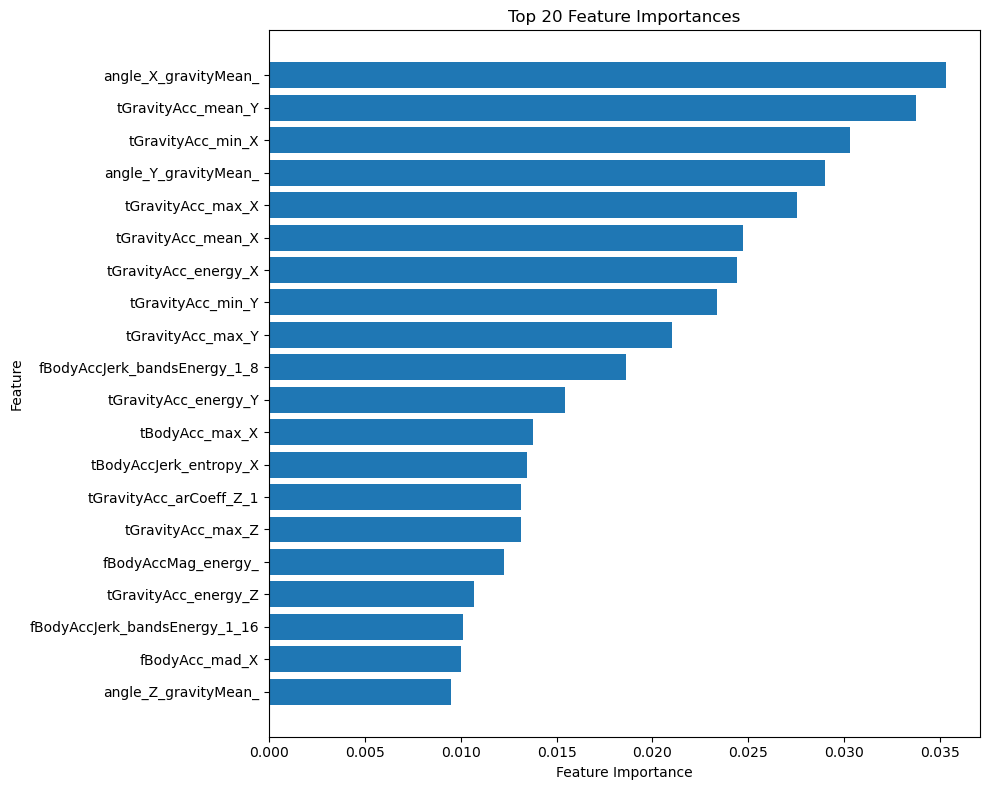

In [36]:
plot_feature_importances(best_model, feature_names=X_train.columns)

# GBM Gradient Boosting Macine 


In [17]:
import os
os.chdir('C:/githome/hipython_rep/')

In [18]:
import re
def clean_feature_name(name):
    # 특수문자 제거: 괄호, 콤마, 하이픈 등
    return re.sub('[^A-Za-z0-9_]+', '_', name)

In [ ]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    # new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
    
    # 중복 이름 처리 + 특수문자 제거
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(
        lambda x: clean_feature_name(x[0] + ('_' + str(x[1]) if x[1] > 0 else '')), axis=1
    )
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [20]:
feature_name_df = pd.read_csv('./data/UCI-HAR_Dataset/features.txt', sep='\s+' ,
                              header=None, names=['column_index', 'column_name'])

new_feature_name_df = get_new_feature_name_df(feature_name_df)

X_train = pd.read_csv('./data/UCI-HAR_Dataset/train/X_train.txt')
X_test =  pd.read_csv('./data/UCI-HAR_Dataset/test/X_test.txt')

C:\Users\Admin\AppData\Local\Temp\ipykernel_8592\3037849969.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: clean_feature_name(x[0] + ('_' + str(x[1]) if x[1] > 0 else '')), axis=1


In [21]:
import pandas as pd

def get_human_dataset( ):
  feature_name_df = pd.read_csv('./data/UCI-HAR_Dataset/features.txt',sep='\s+',
                        header=None, names=['column_index','column_name'])
  new_feature_name_df = get_new_feature_name_df(feature_name_df)
  feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
  X_train = pd.read_csv('./data/UCI-HAR_Dataset/train/X_train.txt',sep='\s+', names=feature_name )
  X_test = pd.read_csv('./data/UCI-HAR_Dataset/test/X_test.txt',sep='\s+', names=feature_name)
  y_train = pd.read_csv('./data/UCI-HAR_Dataset/train/y_train.txt',sep='\s+',header=None,names=['action'])
  y_test = pd.read_csv('./data/UCI-HAR_Dataset/test/y_test.txt',sep='\s+',header=None,names=['action'])
  
  return X_train, X_test, y_train, y_test

In [22]:
X_train, X_test, y_train, y_test = get_human_dataset()

print(X_train.shape, X_test.shape)
print(y_train['action'].value_counts())

C:\Users\Admin\AppData\Local\Temp\ipykernel_8592\3037849969.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: clean_feature_name(x[0] + ('_' + str(x[1]) if x[1] > 0 else '')), axis=1


(7352, 561) (2947, 561)
action
6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: count, dtype: int64


In [23]:
from sklearn.ensemble import GradientBoostingClassifier
# X_train, X_test, y_train, y_test = get_human_dataset()

# print(X_train.shape, X_test.shape)
# print(y_train['action'].value_counts())

In [24]:
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
accuracy_score(y_test, gb_pred)

c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9392602646759416

# XGBOOST 

In [25]:
import xgboost
print(xgboost.__version__)

1.6.2


In [26]:
from sklearn.preprocessing import LabelEncoder
X_train, X_test, y_train, y_test = get_human_dataset()
X_train.shape, y_train.shape

C:\Users\Admin\AppData\Local\Temp\ipykernel_8592\3037849969.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: clean_feature_name(x[0] + ('_' + str(x[1]) if x[1] > 0 else '')), axis=1


((7352, 561), (7352, 1))

In [27]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)  # Series → 1D array
y_test_encoded = le.transform(y_test)

c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [29]:
from xgboost import XGBClassifier
evals = [(X_test, y_test_encoded)]
xgb = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, use_label_encoder=False)
xgb.fit(X_train, y_train_encoded, early_stopping_rounds=40, 
        eval_set=evals, eval_metric='mlogloss', verbose=True)
xgb_pred = xgb.predict(X_test)


c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.58932
[1]	validation_0-mlogloss:1.43267
[2]	validation_0-mlogloss:1.30322
[3]	validation_0-mlogloss:1.19383
[4]	validation_0-mlogloss:1.10067
[5]	validation_0-mlogloss:1.01957
[6]	validation_0-mlogloss:0.94662
[7]	validation_0-mlogloss:0.88249
[8]	validation_0-mlogloss:0.82727
[9]	validation_0-mlogloss:0.77601
[10]	validation_0-mlogloss:0.72925
[11]	validation_0-mlogloss:0.68936
[12]	validation_0-mlogloss:0.65128
[13]	validation_0-mlogloss:0.61844
[14]	validation_0-mlogloss:0.58748
[15]	validation_0-mlogloss:0.55894
[16]	validation_0-mlogloss:0.53410
[17]	validation_0-mlogloss:0.50956
[18]	validation_0-mlogloss:0.48868
[19]	validation_0-mlogloss:0.46809
[20]	validation_0-mlogloss:0.45075
[21]	validation_0-mlogloss:0.43385
[22]	validation_0-mlogloss:0.41768
[23]	validation_0-mlogloss:0.40316
[24]	validation_0-mlogloss:0.38937
[25]	validation_0-mlogloss:0.37645
[26]	validation_0-mlogloss:0.36394
[27]	validation_0-mlogloss:0.35407
[28]	validation_0-mlogloss:0.3

In [30]:
print(classification_report(y_test_encoded, xgb_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       496
           1       0.94      0.94      0.94       471
           2       0.98      0.94      0.96       420
           3       0.94      0.87      0.90       491
           4       0.89      0.95      0.92       532
           5       1.00      1.00      1.00       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



# LGBM

In [31]:
import lightgbm
print(lightgbm.__version__)

3.3.2


In [32]:
X_train, X_test, y_train, y_test = get_human_dataset()
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)  # Series → 1D array
y_test_encoded = le.transform(y_test)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8592\3037849969.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: clean_feature_name(x[0] + ('_' + str(x[1]) if x[1] > 0 else '')), axis=1
c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [34]:
from lightgbm import LGBMClassifier
evals = [(X_test, y_test_encoded)]
lgb = LGBMClassifier(n_estimators=400, objective='multiclass', 
                     num_class=len(np.unique(y_train_encoded)))
lgb.fit(X_train, y_train_encoded, early_stopping_rounds=40, 
        eval_set=evals, eval_metric='multi_logloss', verbose=True)
lgb_pred = lgb.predict(X_test)

c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's multi_logloss: 1.4404
[2]	valid_0's multi_logloss: 1.21574
[3]	valid_0's multi_logloss: 1.04795
[4]	valid_0's multi_logloss: 0.913299
[5]	valid_0's multi_logloss: 0.812686
[6]	valid_0's multi_logloss: 0.725964
[7]	valid_0's multi_logloss: 0.652995
[8]	valid_0's multi_logloss: 0.591598
[9]	valid_0's multi_logloss: 0.539383
[10]	valid_0's multi_logloss: 0.499944
[11]	valid_0's multi_logloss: 0.462273
[12]	valid_0's multi_logloss: 0.429676
[13]	valid_0's multi_logloss: 0.401908
[14]	valid_0's multi_logloss: 0.377718
[15]	valid_0's multi_logloss: 0.357455
[16]	valid_0's multi_logloss: 0.339918
[17]	valid_0's multi_logloss: 0.325799
[18]	valid_0's multi_logloss: 0.314716
[19]	valid_0's multi_logloss: 0.301914
[20]	valid_0's multi_logloss: 0.292755
[21]	valid_0's multi_logloss: 0.284754
[22]	valid_0's multi_logloss: 0.276745
[23]	valid_0's multi_logloss: 0.270387
[24]	valid_0's multi_logloss: 0.265765
[25]	valid_0's multi_logloss: 0.260089
[26]	valid_0's multi_logloss: 0.256178

In [35]:
print(classification_report(y_test_encoded, lgb_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       496
           1       0.93      0.90      0.92       471
           2       0.95      0.92      0.94       420
           3       0.92      0.82      0.87       491
           4       0.85      0.94      0.89       532
           5       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.92      0.93      2947
weighted avg       0.93      0.93      0.93      2947

